In [15]:
#import necessary libraries
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import pandas as pd
import tecplot_io as tec
import h5py
import matplotlib.ticker as tck

In [16]:
#parameters
#Declare some variable 
nturbinex = 4
nturbiney = 4
nturbine = 16
#Diameter of turbine
D = 80
#Other variable
Sx = 7
Sy = 7
#kappa = 0.4
#nu = 1.511e-5
#PEX = 1.45444104333
#PEY = 8.72664625997
#hbar = 0.46
#uinfty = 2.54390548295
dt = 0.68543297937
#Rotational angular period
T_turb = 42.84
U_star = 0.356
H_hub = 70
#Mean finite velocity
U = 11.5258407161
tis = 200
tie = 15000
tii = 200
nti = int((tie - tis) / tii + 1)

In [17]:
#change working directory
path = path = 'd:\post\Project\SWAY_2302'
os.chdir(path)
print("current working directory is: {0}".format(os.getcwd()))

current working directory is: d:\post\Project\SWAY_2302


In [18]:
f= open("mean_field_1d.dat","r")
f.readline()
f.readline()
content=f.readlines()
#print(content)
f.close()

In [19]:
filename = "mean_field_1d.dat"
data = tec.tecplot_reader(filename, [64, 24], 2)

In [20]:
print(data[:,1])
z = data[:,0]
um = data[:,1]
sum = data[:,4]
reynolds = data[:,5]
carnopy = data[:,6]
upwp = data[:,9]
uppwpp = data[:,10]
mkeb_wt = data[:,20]

[0.0018532  0.53686238 0.55218819 0.56795982 0.5822568  0.59515048
 0.60662127 0.612049   0.61705802 0.62165937 0.6258887  0.62980175
 0.63345869 0.63691526 0.64022239 0.64342796 0.64657635 0.6497071
 0.65285325 0.65604023 0.65928559 0.66259892 0.6660071  0.66953648
 0.67318472 0.67694052 0.6808211  0.68484451 0.68901605 0.69332623
 0.69775399 0.70226993 0.70683742 0.71140991 0.71593046 0.7203548
 0.72461943 0.73786854 0.75038489 0.76252189 0.77421127 0.7855425
 0.79651849 0.8071703  0.81741257 0.82727329 0.83679108 0.84605424
 0.85519753 0.86426117 0.87338594 0.88242495 0.89119462 0.89979145
 0.90805487 0.91584007 0.92334411 0.93055702 0.93735817 0.94336179
 0.94844729 0.95220057 0.95609073 0.95609073]


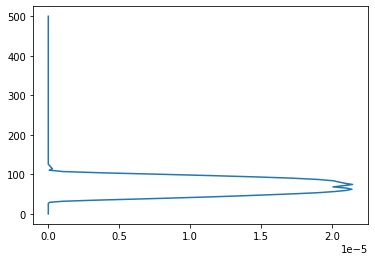

In [21]:
plt.plot(mkeb_wt, z)
plt.show()

In [22]:
#flux_kinetic_energy = um*(reynolds + carnopy)
flux_kinetic_energy = um*sum
data1 = np.zeros((64,3))
data1[:,0] = z/500
data1[:,1] = flux_kinetic_energy
data1[:,2] = mkeb_wt

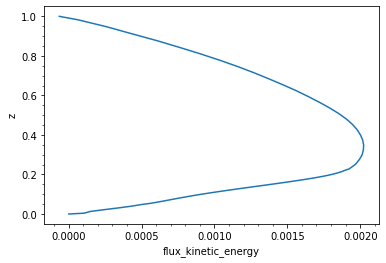

In [23]:
%matplotlib inline
#plt.style.use('classic')
fig, ax = plt.subplots()
plt.plot( flux_kinetic_energy,z/500)
plt.xlabel('flux_kinetic_energy')
plt.ylabel('z')
ax.xaxis.set_minor_locator(tck.AutoMinorLocator())
ax.yaxis.set_minor_locator(tck.AutoMinorLocator())
plt.show()

In [24]:
os.chdir('d:\post')
outputfolder = 'post_result/'
#create output folder named 'post_result' 
if not os.path.exists(outputfolder):
    os.makedirs(outputfolder)
f1 = open( outputfolder + "budget calc.plt",'w')
f1.write("VARIABLES = z/H, phi_e, mkeb_wt  \n")
np.savetxt(f1, data1)
f1.close()

In [25]:
def power_density_average(path):
  #Declare working directory
  os.chdir(path)
  print(os.getcwd())
      #Clean data
  fid = open('log.uref','r')
  content=fid.readlines()
  # Turbine_           1 :angvel=   50.735637598099999      , TSR=   4.4059452767309510      , Uref=  0.86364504796591524
  196034763     

  nline = len(content)
  nt = nline / nturbine
  data=np.zeros((nline,4))

  for i in range(int(nt)):
    for j in range(nturbine):
      i2 = nturbine * i + j
      value=content[i2].split()
      #print(value)
      data[i2,0]=(i+1)*dt
      data[i2,1]=value[3] # angvel
      data[i2,2]=value[6] # TSR
      data[i2,3]=value[9] # Uref
  fid.close()

  np.savetxt('uref.dat', data)
  fid = open('log.cthrust','r')
  content=fid.readlines()
  # Thrust=  0.10233803188671066      , Torque=   6.1668522808625047E-003 , C_Thrust=  0.38109671967396186      , Power=   6.3533464098887757E-002 , C_Power=  0.12840488196034763     

  nline = len(content)
  nt = nline / nturbine
  data=np.zeros((int(nturbine*nt),6))

  for i in range(int(nt)):
    for j in range(nturbine):
      i2 = nturbine * i + j
      value=content[i2].split()
      #print(value)
      data[i2,0]=(i+1)*dt # time
      data[i2,1]=value[1] # thrust
      data[i2,2]=value[4] # torque
      data[i2,3]=value[7] # c_thrust
      data[i2,4]=value[10] # power
      data[i2,5]=float(value[13])*1.0 # c_power
  fid.close()

  np.savetxt('coeff.dat', data)
  #Data Frame
  data = pd.read_csv('coeff.dat', sep = '\s+', header = None)
  data = pd.DataFrame(data)
  x = data[4] #Turbine power
  #rearrange series to array multidimensional
  x = np.array(x)
  x = x.reshape([int(nt), nturbine])

  #calculate power density
  power_density = x/(Sx*Sy*D)
  power_density_average = np.mean(power_density, axis = 1)
  return power_density_average

In [26]:
#function get time variable
#require working directory and return time variable
#input: path
#output: time variable
def get_time(path):
    os.chdir(path)
    data = pd.read_csv('coeff.dat', sep = '\s+', header = None)
    data = pd.DataFrame(data)
    x = data[0]
    time = []
    #Normalized time variable
    for i in range(0, int(len(x)), nturbine):
      #time.append(x[i]*(U/H_hub))
      time.append(x[i]/T_turb)           #Using T_turb
    return time

In [27]:
power_density = power_density_average(path)
time = get_time(path)
data = np.zeros((len(time),2))
data[:,0] = time
data[:,1] = power_density

d:\post\Project\SWAY_2302


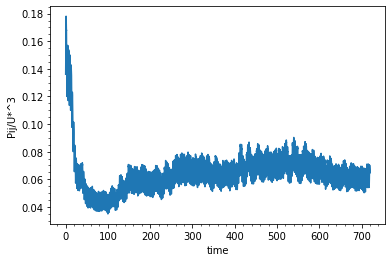

In [28]:
%matplotlib inline
#plt.style.use('classic')
fig, ax = plt.subplots()
plt.plot( data[:,0], data[:,1])
plt.xlabel('time')
plt.ylabel('Pij/U*^3')
ax.xaxis.set_minor_locator(tck.AutoMinorLocator())
ax.yaxis.set_minor_locator(tck.AutoMinorLocator())
plt.show()